In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Conv2D, MaxPool2D, Reshape, Flatten, UpSampling2D, LSTM, GRU
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
import tensorflow.keras.backend as K

In [0]:
train_data_path='/content/drive/My Drive/respiratory-dataset/train/data'
train_labels_path='/content/drive/My Drive/respiratory-dataset/train/labels'
test_data_path='/content/drive/My Drive/respiratory-dataset/test/data'
test_labels_path='/content/drive/My Drive/respiratory-dataset/test/labels'

In [0]:
def get_data(path):
  print(path)
  f = open(path, "r")
  l = f.readlines()
  n_mfcc = 30
  nb_cols = 28
  nb_rows = 860 ## most common audio length
  X = np.zeros((len(l), nb_rows, nb_cols))
  for idx, elm in enumerate(l):
    elm = elm.split('\n')[0]
    vec_str = elm.split(',')

    m = len(vec_str)
    vec = np.zeros(m)
    for i in range(m):
      vec[i] = float(vec_str[i])
    tmp = np.reshape(vec, (int(m / n_mfcc), n_mfcc))
    X[idx] = cv2.resize(tmp, (nb_cols, nb_rows), interpolation=cv2.INTER_AREA)
    if (idx % 100 == 0):
      print("Data nb {}".format(idx))
  f.close()
  return X

def get_labels(path):
  print(path)
  f = open(path, "r")
  s = f.read()
  s = s.split('\n')[0]
  labels_str = s.split(',')
  y = np.zeros(len(labels_str))
  for idx, lab in enumerate(labels_str):
    y[idx] = float(lab)
    if (idx % 100 == 0):
      print("Label nb {}".format(idx))
  return y

In [0]:
X_train = get_data(train_data_path)
y_train = get_labels(train_labels_path)
X_test = get_data(test_data_path)
y_test = get_labels(test_labels_path)

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print("Training data shape {}".format(X_train.shape))
print("Training label shape {}".format(y_train.shape))
print("Testing data shape {}".format(X_train.shape))
print("Testing label shape {}".format(y_test.shape))

Training data shape (2133, 860, 28, 1)
Training label shape (2133,)
Testing data shape (2133, 860, 28, 1)
Testing label shape (47,)


In [46]:
### CNN model
in_shape = (860, 28, 1)
inpt = Input(shape=in_shape)

cnn = Conv2D(32, (3, 3), activation='relu') (inpt)
cnn = BatchNormalization() (cnn)
cnn = MaxPool2D((2, 2)) (cnn)

cnn = Conv2D(64, (3, 3), activation='relu') (cnn)
cnn = BatchNormalization() (cnn)
cnn = MaxPool2D((2, 2)) (cnn)

out = Flatten() (cnn)
out = Dense(4, activation='softmax') (out)
model = Model(inpt, out)
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 860, 28, 1)]      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 858, 26, 32)       320       
_________________________________________________________________
batch_normalization_23 (Batc (None, 858, 26, 32)       128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 429, 13, 32)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 427, 11, 64)       18496     
_________________________________________________________________
batch_normalization_24 (Batc (None, 427, 11, 64)       256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 213, 5, 64)        0  

In [0]:
#adm = Adam(0.001)
rmsprop = RMSprop(0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [49]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1, shuffle=True)

Epoch 1/30
67/67 [==============================] - 39s 575ms/step - loss: 9.3980 - accuracy: 0.6423 - val_loss: 5.7881 - val_accuracy: 0.6170
Epoch 2/30
67/67 [==============================] - 38s 572ms/step - loss: 2.3353 - accuracy: 0.8509 - val_loss: 6.4325 - val_accuracy: 0.5957
Epoch 3/30
67/67 [==============================] - 38s 571ms/step - loss: 0.7074 - accuracy: 0.9273 - val_loss: 6.8048 - val_accuracy: 0.6596
Epoch 4/30
67/67 [==============================] - 38s 572ms/step - loss: 0.7974 - accuracy: 0.9405 - val_loss: 4.6248 - val_accuracy: 0.7872
Epoch 5/30
67/67 [==============================] - 38s 573ms/step - loss: 0.3290 - accuracy: 0.9686 - val_loss: 8.9291 - val_accuracy: 0.7660
Epoch 6/30
67/67 [==============================] - 38s 569ms/step - loss: 0.3471 - accuracy: 0.9756 - val_loss: 8.2997 - val_accuracy: 0.7872
Epoch 7/30
67/67 [==============================] - 38s 570ms/step - loss: 0.2601 - accuracy: 0.9812 - val_loss: 8.7619 - val_accuracy: 0.8298

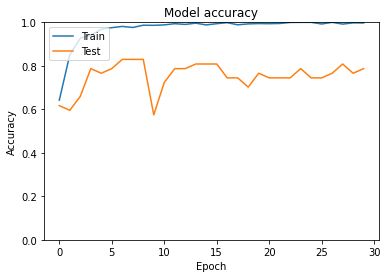

In [51]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
## compute accupacy for each class
def compute_accuracy_class(X, y):
  '''
  Compute accuracy of a class data generator
  return:
  acc_class -> array of accuracy per class
  acc -> total accuracy
  '''
  pred = model.predict(X)
  acc_class, nb_class = np.zeros(4), np.zeros(4)
  acc, n = 0, 0

  for idx, elm in enumerate(pred):
    label_pred = np.argmax(elm)
    label_true = int(y[idx])
    nb_class[label_true] += 1
    if (label_pred == label_true):
      acc += 1
      acc_class[label_true] += 1
    n += 1
  return acc_class / nb_class, acc / n

In [0]:
acc_class, acc = compute_accuracy_class(X_test, y_test)

In [54]:
print("Total Accuracy {}".format(acc))
print("Classes Accuracy {}".format(acc_class))

Total Accuracy 0.7872340425531915
Classes Accuracy [0.28571429 0.7        1.         0.8       ]
